In [1]:
import json
import pymc as pm
import arviz as az
import jax.config as config
config.update('jax_enable_x64', True)
import numpy as np
import matplotlib as plt

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

# import prepare_inference

import pyhf
from pyhf_pymc import prepare_inference
pyhf.set_backend('jax')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

# import MH_inference
# import HMC_inference
from pyhf_pymc import prepare_inference


In [2]:
N = 5
obs = jnp.array([70.]*N)
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

(Array([60., 60., 60., 60., 60.], dtype=float64), [0.0, 1.0])

In [3]:
class VJPOp(pt.Op):
    itypes = [pt.dvector,pt.dvector]  
    otypes = [pt.dvector]

    def __init__(self, vjp_func):
        self.vjp_func = vjp_func

    def perform(self, node, inputs, outputs):
        (at, vector) = inputs
        results = self.vjp_func(at, vector)

        if len(outputs) == 1:
            outputs[0][0] = np.asarray(results, dtype = np.float64)

        for i, r in enumerate(results):
            outputs[i][0] = np.asarray(r, dtype = np.float64)


class ExpDataOp(pt.Op):
    itypes = [pt.dvector]  
    otypes = [pt.dvector]

    def __init__(self, fwd_func):
        self.fwd_func = fwd_func

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = self.fwd_func(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results, dtype = np.float64)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r, dtype = np.float64)

    def grad(self, at_vector, vector):
        return [vjp_op(at_vector[0],vector[0])]
    
def _pyhf_forward(x):
    return model.expected_actualdata(x)

pyhf_fwd_func = jax.jit(_pyhf_forward)
pyhf_vjp_func = jax.jit(lambda at, vector: jax.vjp(_pyhf_forward, at)[1](vector))
                
fwd_op = ExpDataOp(pyhf_fwd_func)
vjp_op = VJPOp(pyhf_vjp_func)

In [4]:
# import prepare_inference
# from prepare_inference import get_target
def priors2pymc(prepared_model):
    unconstr_pars, norm_pars, poiss_pars = [], [], []
    norm_mu, norm_sigma = [], []
    poiss_alpha, poiss_beta = [], []
    model = prepared_model['model']
    obs = prepared_model['obs']
    prior_dict = prepared_model['priors']
    precision = prepared_model['precision']
        
    for key in prior_dict.keys():
        sub_dict = prior_dict[key]

    ## Unconstrained
        if sub_dict['type'] == 'unconstrained':
            unconstr_pars.extend(pm.Gamma('Unconstrained', alpha=sub_dict['input'][0], beta=sub_dict['input'][1]))
        pass

    ## Normal and Poisson constraints            
        if sub_dict['type'] == 'normal':
            norm_mu.append(sub_dict['input'][0])
            norm_sigma.append(sub_dict['input'][1])

        if sub_dict['type'] == 'poisson':
            poiss_alpha.append(sub_dict['input'][0])
            poiss_beta.append(sub_dict['input'][1])

    if np.array(norm_mu, dtype=object).size != 0:
        norm_pars.extend(pm.Normal('Normals', mu=list(np.concatenate(norm_mu)), sigma=list(np.concatenate(norm_sigma))))

    if np.array(poiss_alpha, dtype=object).size != 0:
        poiss_pars.extend(pm.Gamma('Gammas', alpha=list(np.concatenate(poiss_alpha)), beta=list(np.concatenate(poiss_beta))))

    pars = []
    for i in [unconstr_pars, norm_pars, poiss_pars]:
        i = np.array(i)
        if i.size != 0:
            pars.append(i)
    pars = np.concatenate(pars)
    target = prepare_inference.get_target(model)
    final = pt.as_tensor_variable(pars[target.argsort()].tolist())

    return final

In [5]:
# import prepare_inference
unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[4.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

In [6]:
with pm.Model():
    pars = priors2pymc(prepared_model)    
    params = pm.Deterministic('params',pars)
    expected = pm.Deterministic('expected',fwd_op(params))
    data = pm.Poisson('ExpData', expected, observed=obs)

    post_data = pm.sample(1000,  chains = 4, tune=100, init='advi')
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(150)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Initializing NUTS using advi...


Convergence achieved at 6100
Interrupted at 6,099 [3%]: Average Loss = 27.256
Interrupted at 6,099 [3%]: Average Loss = 27.256
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 1 seconds.


Sampling: [ExpData, Normals, Unconstrained]


## my ops

In [7]:
# Jax expected data
@jax.jit
def processed_expData(parameters):
    return model.expected_actualdata(parameters)

jitted_processed_expData = jax.jit(processed_expData)

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
@jax.jit
def vjp_expData(pars, tang_vec):
    _, back = jax.vjp(processed_expData, pars)
    return back(tang_vec)[0]

jitted_vjp_expData = jax.jit(vjp_expData)

# jitted_processed_expData = jax.jit(processed_expData)
# jitted_vjp_expData = jax.jit(vjp_expData)

class VJPOp(Op):

    itypes = [pt.dvector,pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, tangent_vector) = inputs
        results = jitted_vjp_expData(parameters, tangent_vector)

        # if not isinstance(results, (list, tuple)):
        #         results = (results,)
                
        # for i, r in enumerate(results):
        #     outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

vjp_op = VJPOp()

class ExpDataOp(Op):

    itypes = [pt.dvector]  
    otypes = [pt.dvector]

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = jitted_processed_expData(parameters)

        # if len(outputs) == 1:
        #         outputs[0][0] = np.asarray(results)
        #         return
        # for i, r in enumerate(results):
        #         outputs[i][0] = np.asarray(r)
        outputs[0][0] = np.asarray(results)

    def grad(self, inputs, output_gradients):
        (parameters,) = inputs
        (tangent_vector,) = output_gradients
        return [vjp_op(parameters, tangent_vector)]

        
expData_op = ExpDataOp()


In [8]:
# %%timeit
with pm.Model() as m1:
    pars1 = pm.Deterministic('pars1', prepare_inference.priors2pymc(prepared_model))
    ExpData_Det1 = pm.Deterministic('ExpData_Det1', expData_op(pars1))

    # ExpData1 = pm.Poisson("ExpData1", mu=ExpData_Det1, observed=obs)
    ExpData1 = pm.Normal("ExpData1", mu=ExpData_Det1, sigma = float(obs[0])**(0.5), observed=obs)
    
    # pm.init_nuts(init='advi')
    
    print('... pm.sample: ')
    post_data_test = pm.sample(1000, chains=4, cores=4, init='advi')
    print('... pm.sample_porsterior_predictive: ')
    post_pred_test = pm.sample_posterior_predictive(post_data_test)
    print('... pm.sample_prior_predictive: ')
    prior_pred_test = pm.sample_prior_predictive(1000)

... pm.sample: 


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 4800
Interrupted at 4,799 [2%]: Average Loss = 22.835
Interrupted at 4,799 [2%]: Average Loss = 22.835
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [ExpData1, Normals, Unconstrained]


... pm.sample_prior_predictive: 


In [12]:
import matplotlib.pyplot as plt

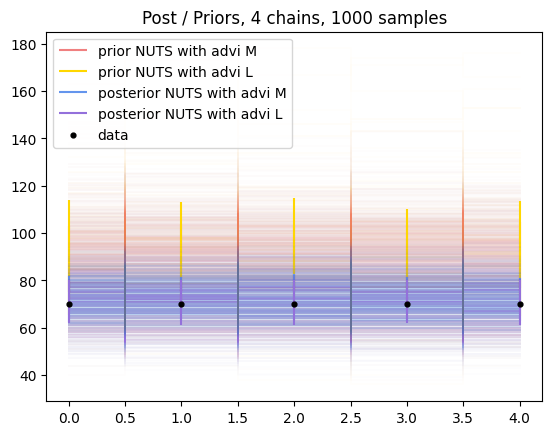

In [13]:
nBins = len(obs)

# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred_test.prior_predictive.ExpData1[0].T, alpha = 0.01, c = 'lightcoral', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_test.prior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'lightcoral', label='prior NUTS with advi M');

plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'gold', label='prior NUTS with advi L');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred_test.posterior_predictive.ExpData1[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_test.posterior_predictive.ExpData1[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='posterior NUTS with advi M')

plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'mediumpurple', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'mediumpurple', label='posterior NUTS with advi L')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post / Priors, 4 chains, 1000 samples')

plt.savefig('M_L_NUTSadvi')
plt.show()